In [1]:
%matplotlib inline
# standard-ish Qiskit libraries
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ

#Insert IBMQ account string here
#IBMQ.save_account('put_your_code_here',overwrite=True)


import time
import pickle


import numpy as np
import binascii
# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise



def flatten(l):
    return [item for sublist in l for item in sublist]

qiskit.__qiskit_version__

{'qiskit-terra': '0.9.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-aqua': '0.6.0',
 'qiskit': '0.12.1',
 'qiskit-aer': '0.3.0',
 'qiskit-ibmq-provider': '0.3.3'}

In [3]:
#set parameters
local=False #run locally (simulation) or on IBM (actual quantum simulation)
initial_layout=[3,4] #set which qubits to use
#initial_layout=[] #empty list if let compiler select which qubits to use


machine='ibmq_vigo'#which IBM machine to use #ibmqx2 #ibmq_vigo #'ibmq_ourense'#'ibmq_16_melbourne' #qasm_simulator
    
dataset="LayoutTest" #name of dataset

if(len(initial_layout)>0): #add layout to dataset name
    dataset+="I"+str(initial_layout[0])+"i"+str(initial_layout[1])
    
if(local==True): #flag dataset if run locally
    dataset="Simulated_"+dataset
    

mode=1 #use which state preparation scheme, 0: scheme with less violation 1: maximal violation

shots=2**13 #should not be larger than 8192 or 2**13
multcircuit=18 #run all circuits x times. IBMQ can maximally run 20 circuits per run, e.g. multcircuit*ncircuits
 

totalCircuits=multcircuit*ncircuits #should not be larger than backend.configuration().max_experiments

floatformat='02.7f'

print("Bits Generated", totalCircuits*shots*2)


Bits Generated 1179648


In [4]:
ncircuits=4 #number of circuits of Bell inequality
nStates=4 #number of states measured
memory=True #get data of all shots

#Load credentials
IBMQ.load_account() 
if(local==True):
    backend = Aer.get_backend('qasm_simulator')
    #get noise and coupling map for simulation
    backendToSimulate = IBMQ.get_provider().get_backend(machine)
    properties = backendToSimulate.properties()
    coupling_map = backendToSimulate.configuration().coupling_map
    noise_model = noise.device.basic_device_noise_model(properties)
    basis_gates = noise_model.basis_gates
else:
    backend = IBMQ.get_provider().get_backend(machine) #get IBM backend
    
if(memory==True):
    if(backend.configuration().memory==False):
        raise NameError("Memory not supported by machine",machine)

if(local==False):
    print("Max shots set",shots,", Max shots allowed",backend.configuration().max_shots)
    print("repeated circuits (multcircuit)",multcircuit,", Maximum value allowed for multcircuit",backend.configuration().max_experiments//ncircuits)
    print("Number circuits set",totalCircuits,", Max circuits allowed",backend.configuration().max_experiments)
    if(shots>backend.configuration().max_shots):
        raise NameError("shots number not supported by machine, reduce to",backend.configuration().max_shots)
    if(totalCircuits>backend.configuration().max_experiments):
        raise NameError("Number circuits too large, try reducing multcircuit to",backend.configuration().max_experiments//ncircuits)


/home/tobias/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


Max shots set 8192 , Max shots allowed 8192
repeated circuits (multcircuit) 18 , Maximum value allowed for multcircuit 18
Number circuits set 72 , Max circuits allowed 75


In [5]:
%qiskit_backend_overview

In [6]:
backend

<IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
Stheory=2*np.sqrt(2) #theoretic maximal value for CHSH inequality
circuitstring=['00','01','10','11'] #measurement settings
dictStates=['00','01','10','11'] #output states
memoryOrderStates=['00','10','01','11'] #states have differnet order for data returned from IBM machine. They are encoded as hex integer, and order of qubits is reverted

#maps measurement results for two quibit measurement 0 or 1 to either +1 or -1. This is used to generate the expectation value.
#stands for bit result ket(00) --> 1, ket(01)-->-1  ket(10)-->-1 ket(11)-->1
mappingBitResultToPM=np.array([1,-1,-1,1]) 

#define CHSHS inequality. We have 4 terms ZZ, ZX, XZ, XX, each generated by one of the circuits. We now assign three terms with +1, and one with -1. 
# The factors are multiplied with the average value of the respective circuits
if(mode==0):
    CHSHfactors=np.array([1,1,-1,1])
elif(mode==1):
    CHSHfactors=np.array([1,1,1,-1])


qr=[None for i in range(ncircuits)]
cr=[None for i in range(ncircuits)]
circuit=[None for i in range(ncircuits)]
theta=-3*np.pi/16
for i in range(ncircuits):
    qr[i] = QuantumRegister(2, 'qr'+str(i))
    cr[i] = ClassicalRegister(2, 'cr'+str(i))
    circuit[i] = QuantumCircuit(qr[i], cr[i])

    circuit[i].h(qr[i][0])
    circuit[i].cx(qr[i][0], qr[i][1])


#two ways to generate CHSH circuit
if(mode==0): #does not generate maximal violation, only up to 2.77
    for i in range(ncircuits):
        circuit[i].u3(theta,0,0,qr[i][0])

    #ZZ gate
    #ZX gate
    circuit[1].h(qr[1][1])

    #XZ gate
    circuit[2].h(qr[2][0])

    #XX
    circuit[3].h(qr[3][0])
    circuit[3].h(qr[3][1])
elif(mode==1): #better method, has maximal violation
    #four measurement settings, generate four circuits
    #ZW
    current=0
    circuit[current].s(qr[current][1])
    circuit[current].h(qr[current][1])
    circuit[current].t(qr[current][1])
    circuit[current].h(qr[current][1])
    
    #ZV
    current=1
    circuit[current].s(qr[current][1])
    circuit[current].h(qr[current][1])
    circuit[current].tdg(qr[current][1])
    circuit[current].h(qr[current][1])
    
    
    #XW
    current=2
    circuit[current].h(qr[current][0])
    circuit[current].s(qr[current][1])
    circuit[current].h(qr[current][1])
    circuit[current].t(qr[current][1])
    circuit[current].h(qr[current][1])
    
    #ZV
    current=3
    circuit[current].h(qr[current][0])
    circuit[current].s(qr[current][1])
    circuit[current].h(qr[current][1])
    circuit[current].tdg(qr[current][1])
    circuit[current].h(qr[current][1])
    
for i in range(ncircuits):
    circuit[i].barrier()
#generate circuits with measurements
circuitMeas=[circuit[i].copy() for i in range(ncircuits)] 
for i in range(ncircuits):
    circuitMeas[i].measure(qr[i], cr[i])
    

circuit[0].draw() #draw circuits without measurements

In [8]:
circuit[1].draw()

In [9]:
circuit[2].draw()

In [10]:
circuit[3].draw()

In [11]:
plotmeas=3
fig=circuitMeas[plotmeas].draw()
fig

In [12]:
# Run the quantum circuit on a statevector simulator backend
sv_simulator = Aer.get_backend('statevector_simulator')

#to generate state, use circuits without measurement
outputvector=[None for i in range(ncircuits)]
for i in range(ncircuits):
    # Execute the circuit
    job = execute(circuit[i], sv_simulator)

    # Get the result
    result = job.result()
    outputstate = result.get_statevector(circuit[i], decimals=20)
    outputvector[i]=outputstate
    
#print(outputvector)



probabilities=np.abs(np.array(outputvector))**2

mappedto01=probabilities*mappingBitResultToPM
summedOverEachTerm=np.sum(mappedto01,axis=1)
S=np.sum(summedOverEachTerm*CHSHfactors)
[S,Stheory,Stheory-S,probabilities] #outputs inequality, theory value, difference between output and thoery, and the probabilities of each circuit


[2.8284271247461894,
 2.8284271247461903,
 8.881784197001252e-16,
 array([[0.4267767, 0.0732233, 0.0732233, 0.4267767],
        [0.4267767, 0.0732233, 0.0732233, 0.4267767],
        [0.4267767, 0.0732233, 0.0732233, 0.4267767],
        [0.0732233, 0.4267767, 0.4267767, 0.0732233]])]

In [14]:


#we run the ncircuits multcircuit times to generate more data per run on the IBM machine
multcircuitMeas=flatten([[circuitMeas[j].copy() for j in range(ncircuits)] for i in range(multcircuit)])

"""
#generate transpiler
if(len(initial_layout)==0):
    trans=transpile(multcircuitMeas,backend)#,initial_layout=[0,1]
else:
    trans=transpile(multcircuitMeas,backend,initial_layout=initial_layout)
"""

'\n#generate transpiler\nif(len(initial_layout)==0):\n    trans=transpile(multcircuitMeas,backend)#,initial_layout=[0,1]\nelse:\n    trans=transpile(multcircuitMeas,backend,initial_layout=initial_layout)\n'

In [370]:
#trans[1].draw()

In [371]:
#trans[2].draw()

In [372]:
#trans[3].draw()

In [15]:
#jobIBMqx2 = execute(circuitMeas, ibmqx2, shots=shots,memory=True)#,meas_return='single',meas_level=0
starttime=time.time()
if(local==True):
    print("Run with noise models of",machine,"locally")
    if(len(initial_layout)==0):
        job = execute(multcircuitMeas, backend, shots=shots,memory=memory,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates)
    else:
        job = execute(multcircuitMeas, backend, shots=shots,memory=memory,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates,initial_layout=initial_layout)
else:
    print("Run on IBM backend",machine)
    if(len(initial_layout)==0):
        print("Run without initial_layout")
        job =execute(multcircuitMeas,backend, shots=shots,memory=memory)
    else:
        print("Run with initial_layout",initial_layout)
        job =execute(multcircuitMeas,backend, shots=shots,memory=memory,initial_layout=initial_layout)

    print("IBM time to submit to queue",time.time()-starttime)

Run on IBM backend ibmq_vigo
Run with initial_layout [3, 4]
IBM time accept time 6.742658853530884


In [16]:
# Grab the results from the job.
print("Waiting for job to finish and retrieve data")
starttime=time.time()
result = job.result()
print("Final wait time",time.time()-starttime)

Waiting for job to finish and retrieve data
Final wait time 680.40039229393


In [17]:
totalshots=shots*multcircuit 
counts=[{} for i in range(ncircuits)]
for i in range(ncircuits):
    for m in range(len(dictStates)):
        counts[i][dictStates[m]]=0
countsVec=[None for i in range(ncircuits)]
countsVecNorm=[None for i in range(ncircuits)]
shotsResult=[None for i in range(ncircuits)]
measSetting=[None for i in range(ncircuits)]

print("Start evaluation of data")
for i in range(ncircuits):
    for k in range(multcircuit):
        for m in range(nStates):
            if(dictStates[m] in result.get_counts(k*ncircuits+i)):
                counts[i][dictStates[m]]+=result.get_counts(k*ncircuits+i)[dictStates[m]]
            else:
                print("Warning: entry ",dictStates[m],"for circuit",k*ncircuits+i,"is zero")
        
#        if(k==0):
#            counts[i] = result.get_counts(k*ncircuits+i)
#        else:
#            for m in range(nStates):
#                counts[i][dictStates[m]]+=result.get_counts(k*ncircuits+i)[dictStates[m]]

                    
    print(counts[i])
    countsVec[i]=np.array([counts[i][dictStates[j]] if dictStates[j] in counts[i] else 0 for j in range(len(dictStates))])
    countsVecNorm[i]=countsVec[i]/np.sum(countsVec[i])
    if(memory==True):
        for k in range(multcircuit):
            if(k==0):
                memCircuit=result.data(k*ncircuits+i)['memory']
            else:
                memCircuit+=result.data(k*ncircuits+i)['memory']
        shotsResult[i]=[memoryOrderStates[int(memCircuit[j],16)] for j in range(totalshots)]
        measSetting[i]=[circuitstring[i] for j in range(totalshots)]
        #from qiskit.visualization import plot_histogram
        #plot_histogram(counts[i])


mappedto01Result=countsVecNorm*mappingBitResultToPM
summedOverEachTermResult=np.sum(mappedto01Result,axis=1)
SResult=np.sum(summedOverEachTermResult*CHSHfactors)

compareExact=[np.transpose([countsVecNorm[i],probabilities[i]]) for i in range(ncircuits)]
    
[SResult,Stheory,Stheory-SResult,summedOverEachTermResult,compareExact]

Start evaluation of data
{'00': 60446, '01': 11035, '10': 12112, '11': 63863}
{'00': 60238, '01': 14854, '10': 13106, '11': 59258}
{'00': 58809, '01': 12961, '10': 15219, '11': 60467}
{'00': 12691, '01': 62384, '10': 61501, '11': 10880}


[2.604899088541667,
 2.8284271247461903,
 0.22352803620452333,
 array([ 0.68604872,  0.62076823,  0.61778429, -0.68029785]),
 [array([[0.40992567, 0.4267767 ],
         [0.07483588, 0.0732233 ],
         [0.08213976, 0.0732233 ],
         [0.43309869, 0.4267767 ]]), array([[0.40851508, 0.4267767 ],
         [0.10073513, 0.0732233 ],
         [0.08888075, 0.0732233 ],
         [0.40186903, 0.4267767 ]]), array([[0.39882406, 0.4267767 ],
         [0.08789741, 0.0732233 ],
         [0.10321045, 0.0732233 ],
         [0.41006809, 0.4267767 ]]), array([[0.08606635, 0.0732233 ],
         [0.42306858, 0.4267767 ],
         [0.41708035, 0.4267767 ],
         [0.07378472, 0.0732233 ]])]]

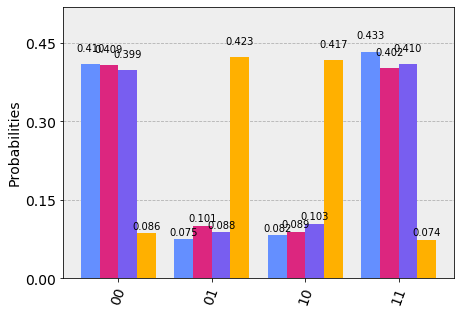

In [18]:
fig=plot_histogram(counts)
fig.savefig("Hist_"+machine+"_"+dataset+"_S"+format(SResult,floatformat).replace(".","_")+".pdf")
fig

In [19]:
counts

[{'00': 60446, '01': 11035, '10': 12112, '11': 63863},
 {'00': 60238, '01': 14854, '10': 13106, '11': 59258},
 {'00': 58809, '01': 12961, '10': 15219, '11': 60467},
 {'00': 12691, '01': 62384, '10': 61501, '11': 10880}]

In [20]:
#Output data

#file with 
resultA=[] #alice measuremnt result
resultB=[] #bob measurement result
measSettingA=[] #alice measurement Setting
measSettingB=[] #bob measurement Setting
#shuffleCircuits=flatten([[np.ones(shots)*i,np.arange(shots)] for i in range(ncircuits)])
if(memory==True):
    print("Generating output bits of measurement results and settings for alice and Bob")
    shuffleCircuits=flatten([np.ones(totalshots,dtype=int)*i for i in range(ncircuits)]) #shuffle differen measurement types
    np.random.shuffle(shuffleCircuits)
    for i in range(ncircuits):
        for j in range(totalshots):
            circuitindex=shuffleCircuits[i*totalshots+j] #use shuffled index
            resultA+=shotsResult[circuitindex][j][0]
            resultB+=shotsResult[circuitindex][j][1]
            measSettingA+=measSetting[circuitindex][j][0]
            measSettingB+=measSetting[circuitindex][j][1]

            #output 
    with open('outputCHSH_'+machine+'_'+dataset+'.txt', 'w') as the_file:
        the_file.write("".join(resultA)+"\n")
        the_file.write("".join(resultB)+"\n")
        the_file.write("".join(measSettingA)+"\n")
        the_file.write("".join(measSettingB))


    with open('outputCHSH_'+machine+'_Concat_'+dataset+'.txt', 'w') as the_file:
        the_file.write("".join(resultA)+"\n")
        the_file.write("".join(resultB))
    
    
#dump all data in pickle
outfile=open( "outputCHSH_"+machine+"_"+dataset+".pcl", "wb" )
pickle.dump([counts,countsVecNorm,shotsResult,measSetting,SResult,Stheory,summedOverEachTermResult,compareExact,resultA,resultB,measSettingA,measSettingB], outfile)
outfile.close()

print("Finish output")

Generating output bits of measurement results and settings for alice and Bob
Finish output
